In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

breakouts = pd.read_excel('backtest_results_6.xlsx')

In [114]:
breakouts['portfolio'] = breakouts['portfolio'].ffill()

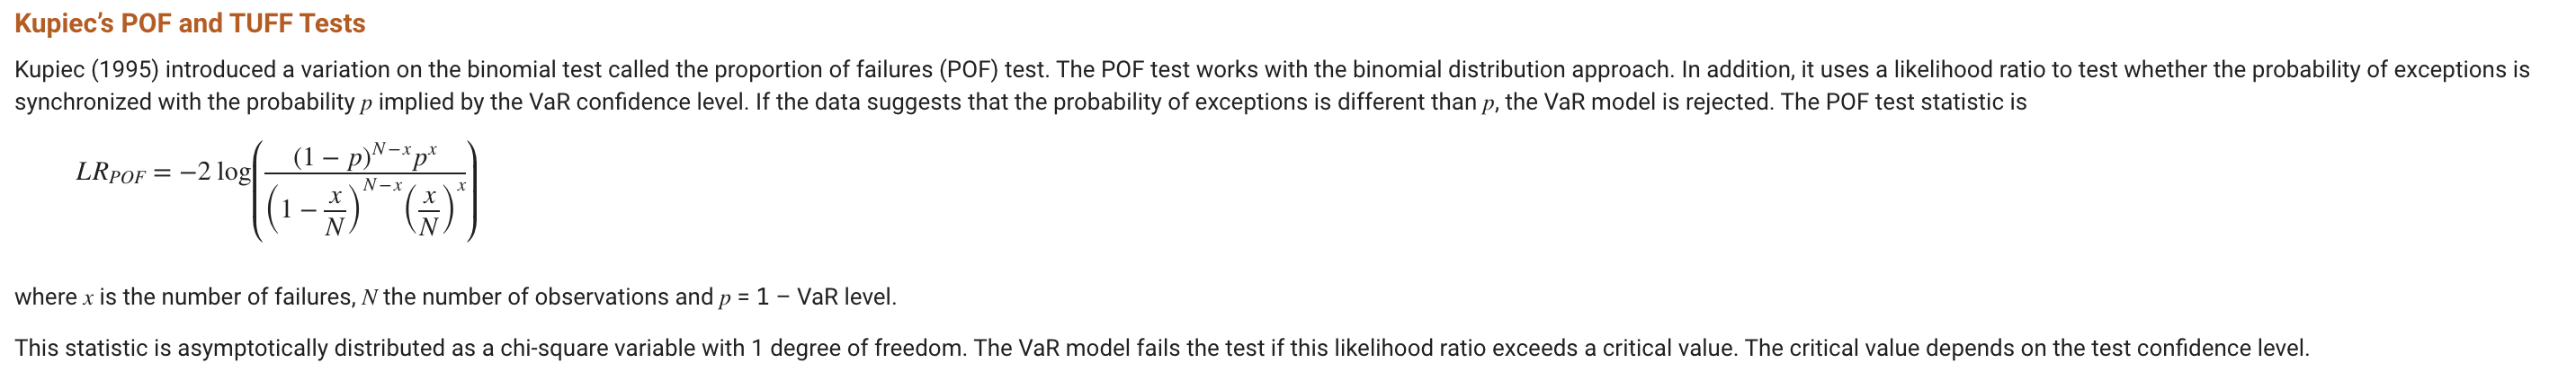

- Описание: Тест Kupiec, также известный как тест пропорции неудач, оценивает, соответствует ли количество нарушений (выходы за пределы заданного уровня VaR) предполагаемой частоте риска.
- Мотивация:
  - Простота и Лёгкость в Реализации: Тест прост в реализации и требует минимального количества данных (фактические нарушения и предполагаемая частота).

In [22]:
def kupiec_pof_test(x, n, p=0.01):
    """
    Kupiec POF test to evaluate the accuracy of VaR models.

    Parameters:
    - x : int
       number of exceptions (actual < VaR).sum()
    - n : int
        number of observations.
    - p : float
        VaR level

    Returns:
    - LRuc : float
        The likelihood ratio under unconditional coverage hypothesis.
    - p_value : float
        The p-value associated with the LRuc statistic.
    """

    # Empirical estimate of the tail probability
    pi_hat = x / n
    
    # Kupiec Test Statistic (Likelihood Ratio for Unconditional Coverage)
    LRuc = -2 * ( 
        np.log((1 - p) ** (n - x) * p ** x) - 
        np.log((1 - pi_hat) ** (n - x) * pi_hat ** x)
    )

    # p-value
    p_value = 1 - stats.chi2.cdf(LRuc, 1)

    return LRuc, p_value

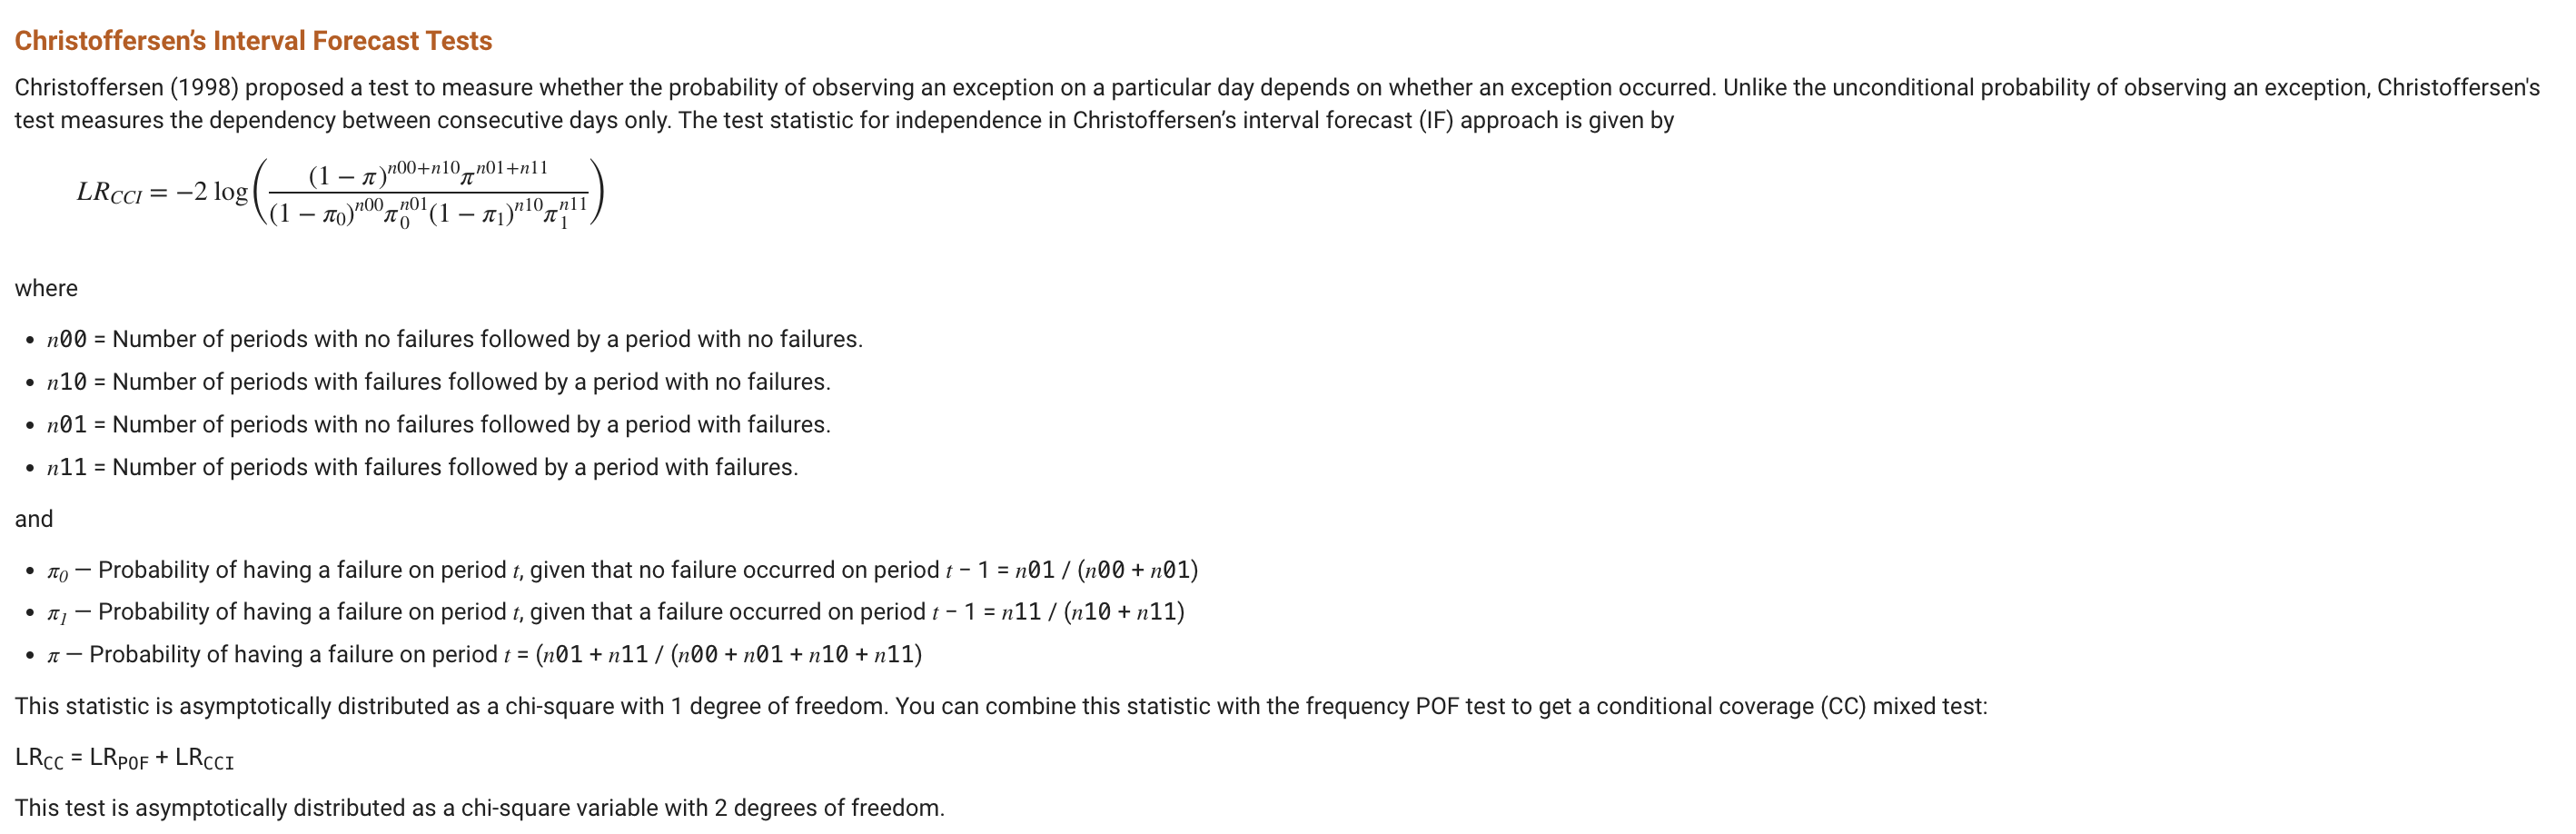

Основное Преимущество: Учет Временной Зависимости
- Описание: Тест Christoffersen включает оценку как частоты нарушений, так и временной зависимости между ними, что позволяет более детально оценивать качество модели VaR.
- Мотивация:
  - Учет Кластеризации Нарушений: Тест оценивает, существуют ли временные зависимости или кластеризация нарушений, что важно для более точной оценки рисков.

In [110]:
def christoffersen_independence_test(exceptions):
    # Calculate exceptions (failures) where the actual return is less than the Value at Risk.
    
    # Calculate the necessary counts
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(exceptions)):
        if exceptions[i-1] == 0 and exceptions[i] == 0:
            n00 += 1
        elif exceptions[i-1] == 0 and exceptions[i] == 1:
            n01 += 1
        elif exceptions[i-1] == 1 and exceptions[i] == 0:
            n10 += 1
        elif exceptions[i-1] == 1 and exceptions[i] == 1:
            n11 += 1

    # Calculate probabilities
    pi0 = 1 + n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = 1 + n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0

    # Calculate the likelihood ratio
    likelihood_ratio = -2 * np.log(
        ((1 - pi)**(n00 + n10) * pi**(n01 + n11)) / 
        ((1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11)
    ) if ((1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11) > 0 else -np.inf

    # Degrees of freedom
    degrees_of_freedom = 1

    # Calculate p-value
    p_value = chi2.sf(likelihood_ratio, degrees_of_freedom)

    return likelihood_ratio, p_value


In [149]:
for i, (portfolio, horizon, success, trials, _, _) in breakouts.iterrows():
    stat, pvalue = kupiec_pof_test(trials - success, trials)
    print(f'Kupiec_pof_test for {portfolio} with {horizon=} {stat=:.2f}, {pvalue=:.4f}')
    if success == trials:
        stat, pvalue = christoffersen_independence_test(np.full(trials, 0))
        print(f'Christoffersen_independence_test for {portfolio} with {horizon=} {stat=:.2f}, {pvalue=:.4f}')
    else:
        raise ValueException()

Kupiec_pof_test for portfolio with horizon=1 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for portfolio with horizon=1 stat=-inf, pvalue=1.0000
Kupiec_pof_test for portfolio with horizon=10 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for portfolio with horizon=10 stat=-inf, pvalue=1.0000
Kupiec_pof_test for shares with horizon=1 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for shares with horizon=1 stat=-inf, pvalue=1.0000
Kupiec_pof_test for shares with horizon=10 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for shares with horizon=10 stat=-inf, pvalue=1.0000
Kupiec_pof_test for bonds with horizon=1 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for bonds with horizon=1 stat=-inf, pvalue=1.0000
Kupiec_pof_test for bonds with horizon=10 stat=4.52, pvalue=0.0334
Christoffersen_independence_test for bonds with horizon=10 stat=-inf, pvalue=1.0000
Kupiec_pof_test for currencies with horizon=1 stat=4.52, pvalue=0.0334
Christoff